# DS - Application Project <br>
# Developement of a Recommender System for Employee Skills - Descriptive analysis

## Preprocessing

In [8]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy.interpolate import make_interp_spline
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

Import data:

In [9]:
df = pd.read_csv("data/person-skills_2022-06-27.csv",sep=";") 
df.head(5)

,person,skill,category
0,12,Windows NT/2000/XP,Betriebssystem
1,12,MAC OS X,Betriebssystem
2,12,Windows 7,Betriebssystem
3,12,Windows 8,Betriebssystem
4,12,iOS,Betriebssystem


In [10]:
data_categories = df[["skill","category"]].drop_duplicates()
data_categories.head(5)

,skill,category
0,Windows NT/2000/XP,Betriebssystem
1,MAC OS X,Betriebssystem
2,Windows 7,Betriebssystem
3,Windows 8,Betriebssystem
4,iOS,Betriebssystem


Declaring various aiding variables

In [11]:
PERSONS = df["person"].unique()
SKILLS = sorted(df["skill"].unique())
CATEGORIES = df["category"].unique()
employee_dict = {}
for n in range(0,len(PERSONS)):
    employee_dict[n] = PERSONS[n]


## Descriptive Statistics

Check for each skill how many employees are proficent in that certain skill:

In [12]:
df_value_counts = df.skill.value_counts()
df_value_counts = df_value_counts.to_frame().rename(columns = {"skill" : "number_of_users"}).reset_index().rename(columns={'index': 'skill'})
df_value_counts

,skill,number_of_users
0,Englisch,315
1,MySQL,282
2,SCRUM,276
3,GIT,267
4,HTML,266
...,...,...
729,Final Cut,1
730,Datadog,1
731,Lead Generierung,1
732,Pulumi,1


in percent:

In [13]:
df_value_counts["number_of_users_%"] = df_value_counts.number_of_users/len(df_value_counts.number_of_users/len(df))
df_value_counts

,skill,number_of_users,number_of_users_%
0,Englisch,315,0.429155
1,MySQL,282,0.384196
2,SCRUM,276,0.376022
3,GIT,267,0.363760
4,HTML,266,0.362398
...,...,...,...
729,Final Cut,1,0.001362
730,Datadog,1,0.001362
731,Lead Generierung,1,0.001362
732,Pulumi,1,0.001362


In [14]:
df_value_counts[(df_value_counts.number_of_users == 10)]

,skill,number_of_users,number_of_users_%
397,Browser Debugging,10,0.013624
398,SharePoint,10,0.013624
399,Konzeption,10,0.013624
400,Sitecore,10,0.013624
401,Product Owner,10,0.013624
402,ActiveX,10,0.013624
403,ITCSS,10,0.013624
404,Laravel,10,0.013624
405,OpenShop,10,0.013624
406,Rational Unified Process (RUP),10,0.013624


### Plot the number of users for each skill

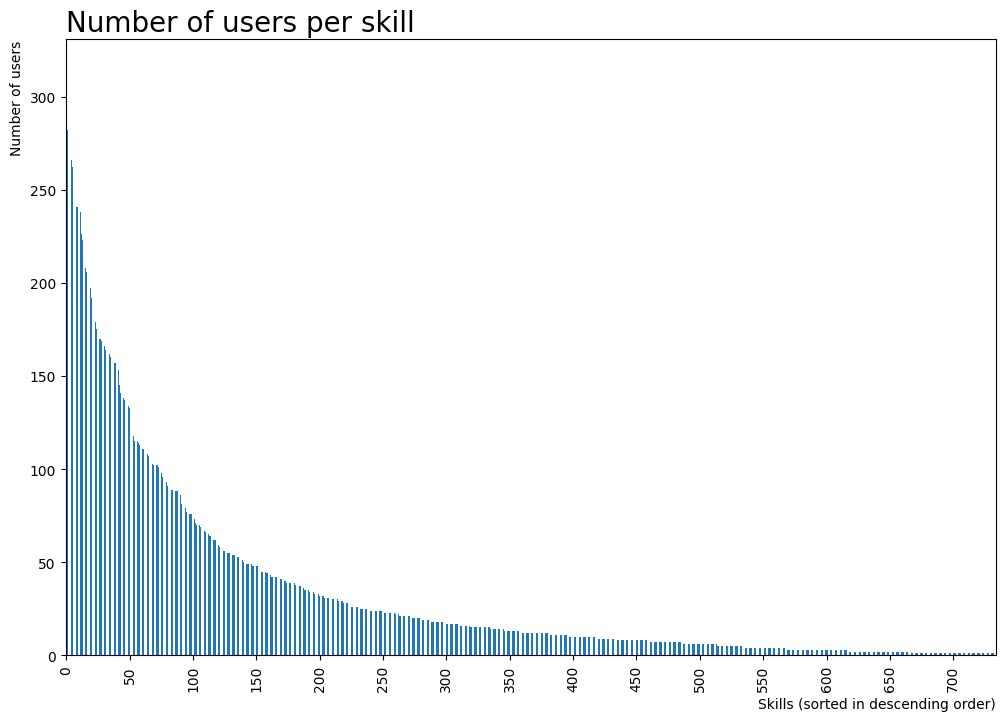

In [15]:
plt.figure(figsize=(12, 8))
ax = df_value_counts.number_of_users.plot(kind="bar")

##########
# Set the indexes as x labels
##########
ax.set_xticklabels(df_value_counts.index)

##########
# Set the x ticks   
##########
ax.set_xticks(np.arange(0,750,50).tolist())

##########
# Set the titles
##########
ax.set_title("Number of users per skill", fontsize=20,loc = 'left')
ax.set_xlabel("Skills (sorted in descending order)", fontsize=10,loc='right')
ax.set_ylabel("Number of users", fontsize=10,loc = 'top')
#plt.savefig("plots/number_of_users_per_skill.png")
plt.show()

**Description of the plot** <br>
On a descriptive level, the visualization shows impressively that the number of employees decreases exponentially with a higher index. While the skill with index 0 still has 315 users in the company, only 75 employees are proficient in the skill represented by index 100. All skills with an index of 397 or higher have a maximum of 10 users in the company.<br>
These observations lead to the conclusion that a large number of rare skills exist in Neusta. Especially these rare skills ensure that the matrix is sparse when setting up a user-item matrix in which the users are represented as rows and the skills as columns. However, such rare skills can also be understood as a differentiating feature for the users and thus form an important source of information for the recommender system

### Plot the number of skills within a category

In [16]:
df_skills_in_categories = df[["skill","category"]].drop_duplicates() 
df_skills_in_categories = df_skills_in_categories.groupby(['category'])["skill"].count().sort_values(ascending= False).to_frame().rename(columns = {"skill" : "number_of_skills"}).reset_index()
df_skills_in_categories.head(5)

,category,number_of_skills
0,Sonstige,98
1,Webentwicklung,57
2,Einsatzfelder / Erfahrungen / Schwerpunkte,47
3,Java Frameworks,43
4,Betriebssystem,37


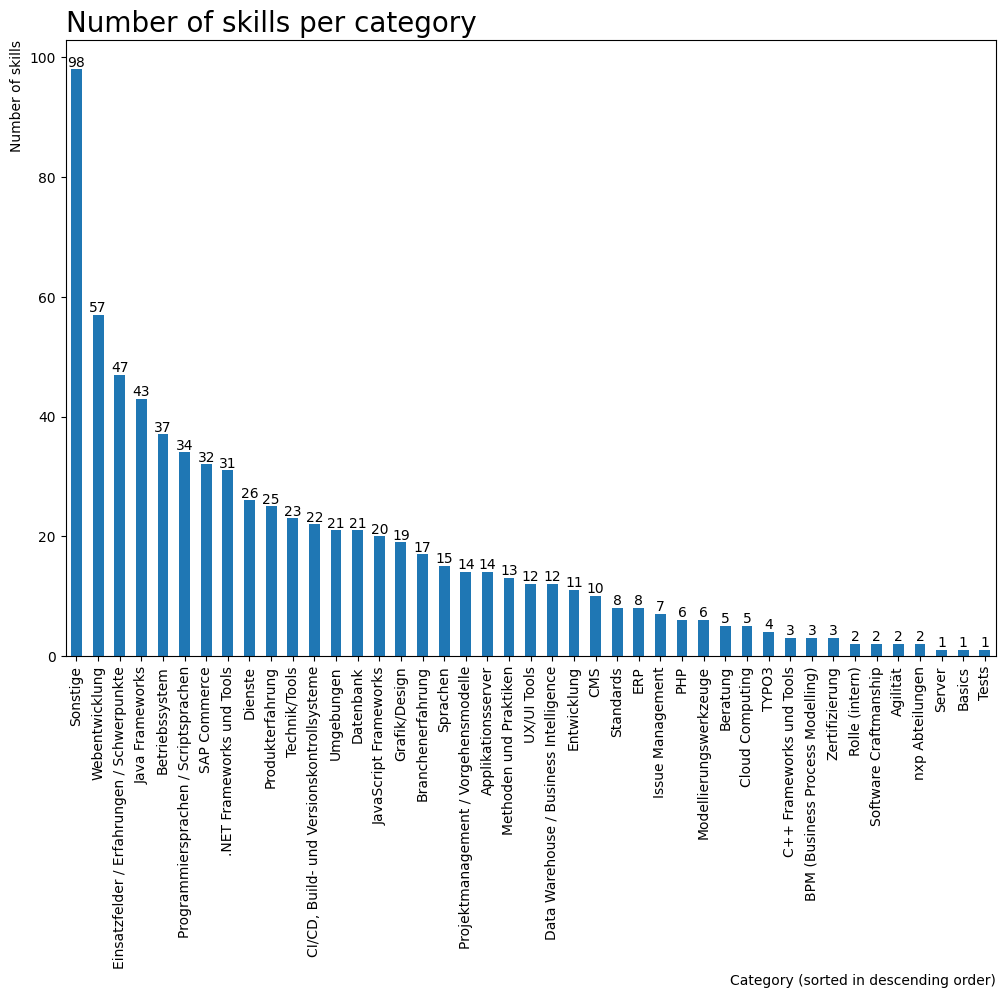

In [17]:
plt.figure(figsize=(12, 8))
ax = df_skills_in_categories.number_of_skills.plot(kind="bar")

# ##########
# # Set the categories as x labels
# ##########
ax.set_xticklabels(df_skills_in_categories.category)

###########
# Set bar labels
###########
rects = ax.patches
for rect, label in zip(rects, df_skills_in_categories.number_of_skills):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
        ha='center', va='bottom')

##########
# Set the titles
##########
ax.set_title("Number of skills per category", fontsize=20,loc = 'left')
ax.set_xlabel("Category (sorted in descending order)", fontsize=10,loc='right')
ax.set_ylabel("Number of skills", fontsize=10,loc = 'top')
#plt.savefig("plots/number_of_skills_per_category.png")
plt.show()

**Description of the plot**

### Categorize the skills by their number of users and plot the distribution

In [18]:
df_categorized = df.groupby(["category", "skill"])["skill"].count().to_frame().rename(columns={"skill": "number_of_users"}).reset_index()
df_categorized.head(5)

,category,skill,number_of_users
0,.NET Frameworks und Tools,.NET Compact Framework,28
1,.NET Frameworks und Tools,.NET Core,10
2,.NET Frameworks und Tools,.NET Framework,87
3,.NET Frameworks und Tools,ADO.NET,23
4,.NET Frameworks und Tools,ASP Generalist,29


In [19]:
graduations = np.array([])

for i in df_categorized.number_of_users:
    if i > 200: 
        
        graduations = np.append(graduations,"> 200")
    elif i >= 100:
        graduations = np.append(graduations,"100 - 200")
    elif i >= 50:
        graduations = np.append(graduations,"50 - 100")
    elif i >= 10:
        graduations = np.append(graduations,"10 - 50")
    else:
        graduations = np.append(graduations,"< 10")

df_categorized["frequence_category"] = graduations
df_categorized

,category,skill,number_of_users,frequence_category
0,.NET Frameworks und Tools,.NET Compact Framework,28,10 - 50
1,.NET Frameworks und Tools,.NET Core,10,10 - 50
2,.NET Frameworks und Tools,.NET Framework,87,50 - 100
3,.NET Frameworks und Tools,ADO.NET,23,10 - 50
4,.NET Frameworks und Tools,ASP Generalist,29,10 - 50
...,...,...,...,...
738,Zertifizierung,CSM – Scrum Master,45,10 - 50
739,Zertifizierung,CSPO – Product Owner,7,< 10
740,Zertifizierung,ISTQB - Foundation Level,10,10 - 50
741,nxp Abteilungen,Pimcore,1,< 10


In [20]:
df_categorized[df_categorized.frequence_category =="> 200"]

,category,skill,number_of_users,frequence_category
121,"CI/CD, Build- und Versionskontrollsysteme",GIT,267,> 200
174,Datenbank,MySQL,282,> 200
179,Datenbank,SQL,241,> 200
231,Einsatzfelder / Erfahrungen / Schwerpunkte,Implementierung,223,> 200
296,Issue Management,JIRA,255,> 200
375,Methoden und Praktiken,Test Driven Development (TDD),241,> 200
376,Methoden und Praktiken,Unit Tests (Komponententests),238,> 200
429,Programmiersprachen / Scriptsprachen,Java,241,> 200
430,Programmiersprachen / Scriptsprachen,JavaScript,262,> 200
457,Projektmanagement / Vorgehensmodelle,SCRUM,276,> 200


Check how often each of our customized categories occurs:

In [21]:
df_categorized = df_categorized.value_counts("frequence_category").to_frame().reset_index().rename(columns={0: "number_of_skills"})
df_categorized

,frequence_category,number_of_skills
0,< 10,324
1,10 - 50,277
2,50 - 100,68
3,100 - 200,57
4,> 200,17


Visualization:

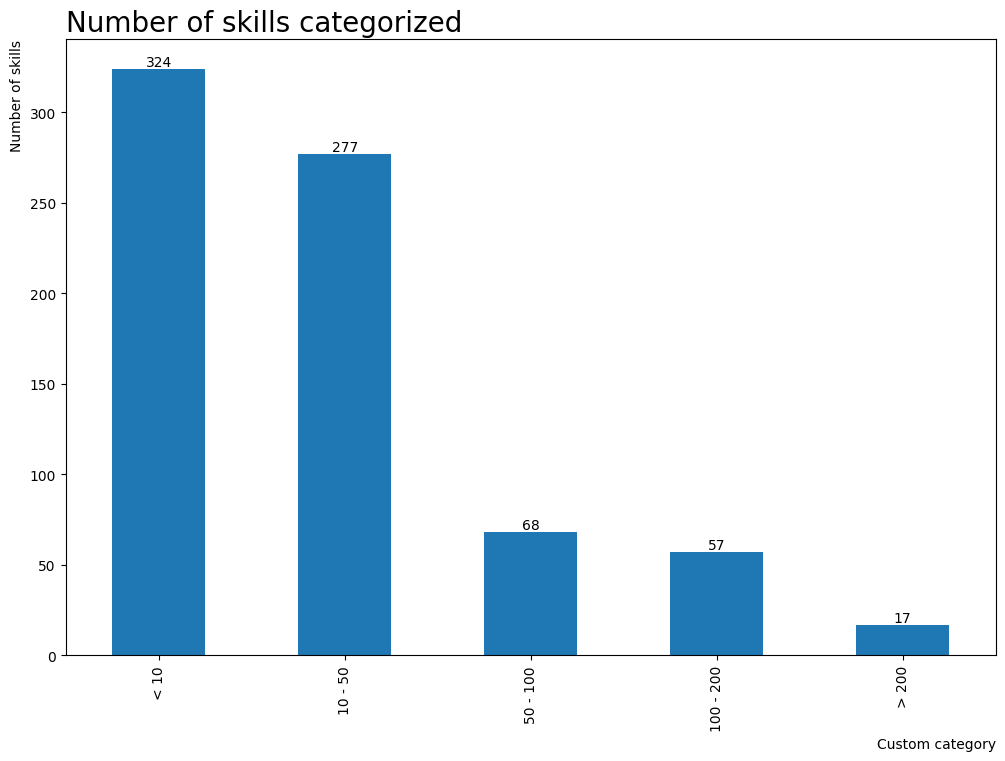

In [22]:
plt.figure(figsize=(12, 8))
ax = df_categorized.number_of_skills.plot(kind="bar")

# ##########
# # Set the categories as x labels
# ##########
ax.set_xticklabels(df_categorized.frequence_category)

###########
# Set bar labels
###########
rects = ax.patches
for rect, label in zip(rects, df_categorized.number_of_skills):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
        ha='center', va='bottom')

##########
# Set the titles
##########
ax.set_title("Number of skills categorized", fontsize=20,loc = 'left')
ax.set_xlabel("Custom category", fontsize=10,loc='right')
ax.set_ylabel("Number of skills", fontsize=10,loc = 'top')
#plt.savefig("plots/number_of_skills_categorized.png")
plt.show()

**Description of the plot**

### Calculate the cosine similarity

In [23]:
# Create a user-item matrix
df["count"] = 1
matrix = df.pivot_table('count', index='person', columns="skill").fillna(0).astype(int).reset_index(drop=True)
#Set the index name = "userid"
matrix.index.names = ["userids"]
matrix

skill,.NET Compact Framework,.NET Core,.NET Framework,3D-Modellierung,ABAP,ADO.NET,AIX,ARIS,ARIS ITArchitect,AS400,...,ramda.js,ranorex,samba,script.aculo.us,varnish,visual paradigm,vnc,vs code,xHTML,xtCommerce
userids,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Function to calculate the cosine similarity:

In [24]:
def calculate_similarity(data_items):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(data_items)
    similarities = cosine_similarity(data_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index= data_items.columns, columns= data_items.columns)
    return sim

In [25]:
sim_matrix = calculate_similarity(matrix)
sim_matrix

skill,.NET Compact Framework,.NET Core,.NET Framework,3D-Modellierung,ABAP,ADO.NET,AIX,ARIS,ARIS ITArchitect,AS400,...,ramda.js,ranorex,samba,script.aculo.us,varnish,visual paradigm,vnc,vs code,xHTML,xtCommerce
skill,,,,,,,,,,,,,,,,,,,,,
.NET Compact Framework,1.000000,0.124035,0.319077,0.224133,0.000000,0.449823,0.065372,0.000000,0.087706,0.295656,...,0.000000,0.000000,0.266880,0.054393,0.000000,0.000000,0.218927,0.000000,0.336581,0.083624
.NET Core,0.124035,1.000000,0.274398,0.000000,0.000000,0.263752,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039223,0.091287,0.030151,0.000000
.NET Framework,0.319077,0.274398,1.000000,0.263416,0.000000,0.429715,0.108465,0.115045,0.097014,0.228924,...,0.000000,0.076696,0.221404,0.090249,0.000000,0.038348,0.309429,0.125245,0.320594,0.069375
3D-Modellierung,0.224133,0.000000,0.263416,1.000000,0.082479,0.089363,0.095238,0.050508,0.063888,0.086146,...,0.000000,0.000000,0.311046,0.198107,0.071429,0.050508,0.265789,0.041239,0.408627,0.152286
ABAP,0.000000,0.000000,0.000000,0.082479,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.204124,0.000000,0.000000,0.055048,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
visual paradigm,0.000000,0.000000,0.038348,0.050508,0.204124,0.000000,0.000000,0.125000,0.000000,0.000000,...,0.000000,0.000000,0.096225,0.000000,0.000000,1.000000,0.043853,0.000000,0.033710,0.000000
vnc,0.218927,0.039223,0.309429,0.265789,0.000000,0.155178,0.206725,0.043853,0.110940,0.149592,...,0.000000,0.000000,0.573886,0.275208,0.124035,0.043853,1.000000,0.143223,0.425745,0.343776
vs code,0.000000,0.091287,0.125245,0.041239,0.000000,0.060193,0.000000,0.000000,0.000000,0.087039,...,0.000000,0.000000,0.157135,0.080064,0.144338,0.000000,0.143223,1.000000,0.137620,0.123091


Conventionally a heatmap is ideal to plot a similarity-matrix. However, the similartiy matrix listed here has a size of 734x734, which makes the visualization of all columns and rows very messy. <br>Therefore only a section of the similarity matrix is plotted in the following, so that a first visual impression of the cosine similarity of the skills can be gained. The following matrix is a 10x10 matrix and contains the first 10 rows and columns of the complete similarity matrix:

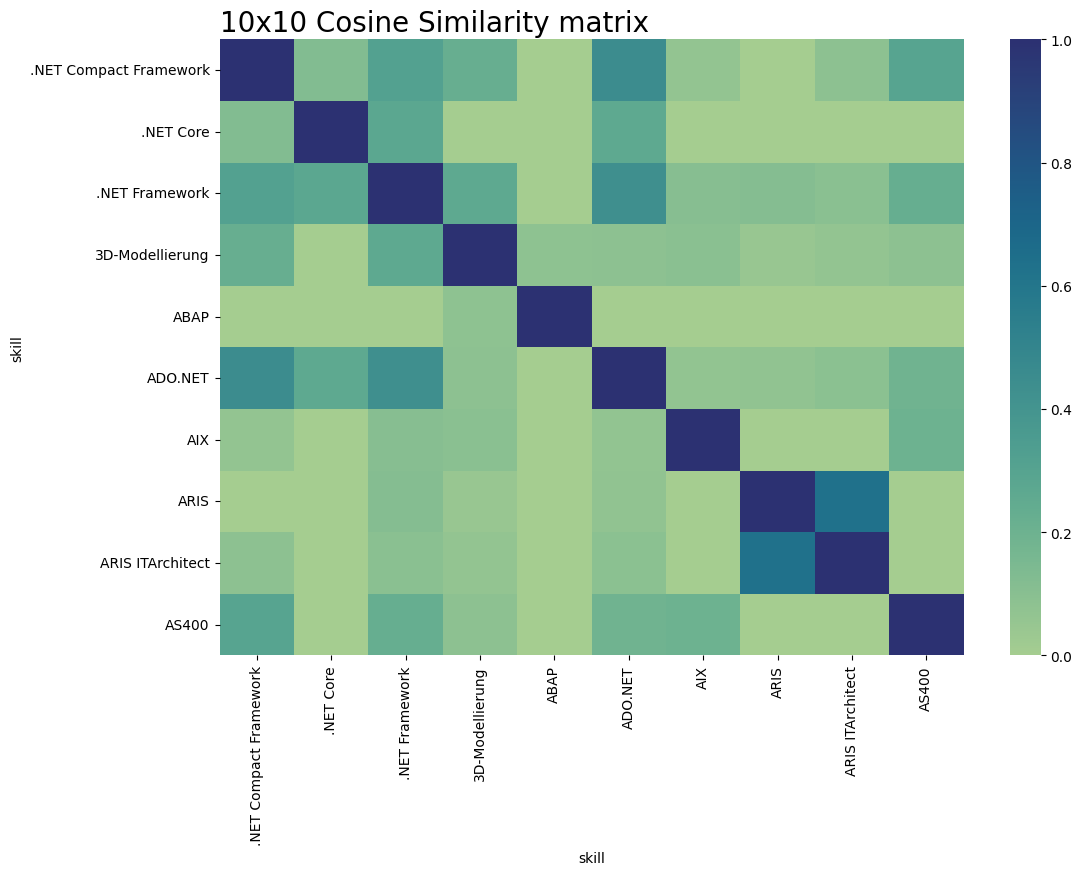

In [26]:
plt.figure(figsize=(12, 8))
ax = sns.heatmap(sim_matrix.iloc[0:10,0:10] ,vmin=0, vmax=1 ,cmap="crest")
ax.set_title("10x10 Cosine Similarity matrix", fontsize=20, loc = 'left')
plt.show()

Show size of categories: 

In [31]:
skills_to_category = pd.read_csv("data/mitarbeiterportal-skills_2022-06-21.csv",sep=";",header=None).rename(columns={0: 'skill',1:'category'})
skills_to_category

,skill,category
0,(Customer) Identity & Access Management Anbindung,SAP Commerce
1,.NET Compact Framework,.NET Frameworks und Tools
2,.NET Core,.NET Frameworks und Tools
3,.NET Framework,.NET Frameworks und Tools
4,.net Werkbank,\0
...,...,...
771,YAML,Sonstige
772,Yii,Webentwicklung
773,Zend,\0
774,Zend,Webentwicklung


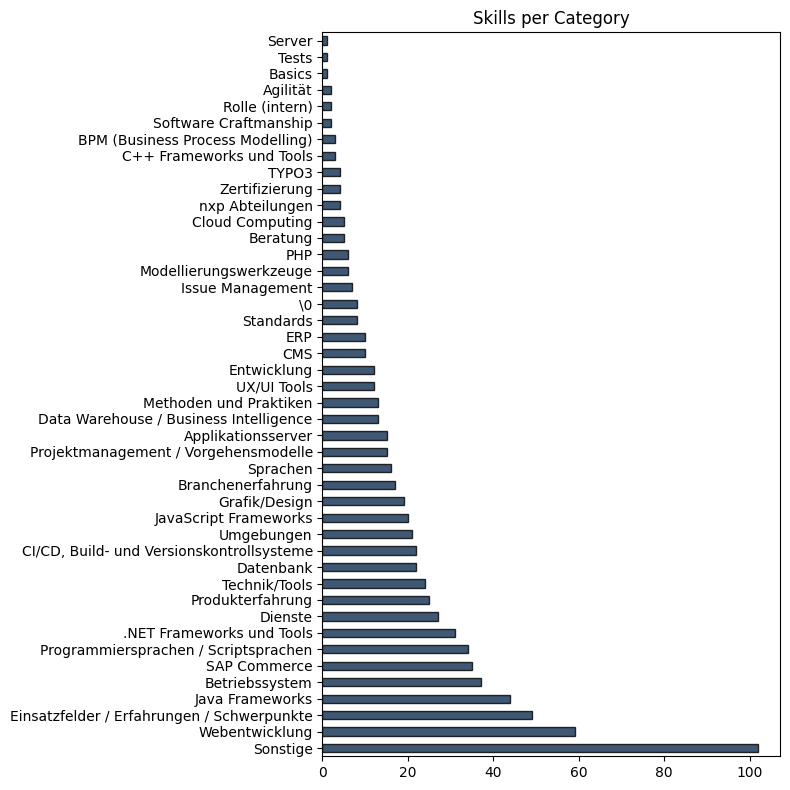

In [40]:
fig, ax = plt.subplots(figsize=(8,8))
skills_to_category["category"].value_counts().plot(ax=ax,kind="barh",title="Skills per Category",                            color="#112e51",
                            edgecolor='k',
                            alpha=0.8)
plt.tight_layout()
plt.savefig("skills_per_category")

Books: 

https://www.taylorfrancis.com/books/edit/10.1201/9780367631888/recommender-systems-pavan-kumar-vairachilai-sirisha-potluri-sachi-nandan-mohanty

https://beluga.sub.uni-hamburg.de/vufind/Record/1656091313?rank=1

Drop certain skill categories: 